# Computation of velocity and acceleration by differentiation

- load Elipot GDP data
- replace -1.000000e34 by nan values
- compute velocity and acceleration with pynsitu.geo.compute_velocities and pynsitu.geo.compute_acceleration
- store all in parquet

In [1]:
import os
from glob import glob

import numpy as np
import pandas as pd
import xarray as xr
import dask.dataframe as dd
import dask.array as da

# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
# import geopandas as gpd
from shapely.geometry import Polygon

%matplotlib inline
from matplotlib import pyplot as plt


import drifters.utils as ut
import pynsitu as pin

from dask.delayed import delayed  # important to read parquet correctly

In [2]:
from dask.distributed import Client

if True:
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client

    cluster = PBSCluster(cores=3, processes=3, walltime="04:00:00")
    w = cluster.scale(jobs=5)
else:
    from dask.distributed import LocalCluster

    cluster = LocalCluster()

client = Client(cluster)
client

/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask_jobqueue/core.py:237: FutureWarning: extra has been renamed to worker_extra_args. You are still using it (even if only set to []; please also check config files). If you did not set worker_extra_args yet, extra will be respected for now, but it will be removed in a future release. If you already set worker_extra_args, extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mdemol/.min

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.1.1:8787/status,
Dashboard: http://10.148.1.1:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.1.1:34975,Workers: 0
Dashboard: http://10.148.1.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Load Elipot GDP data

In [3]:
# load data

col_sel = [
    "time",
    "id",
    "lon",
    "lat",
    "ve",
    "vn",
    "typebuoy",
    "gap",
    "deploy_date",
    "deploy_lat",
    "deploy_lon",
    "end_date",
    "end_lat",
    "end_lon",
    "drogue_lost_date",
    "typedeath",
    "lon360",
    "err_lat",
    "err_lon",
    "err_ve",
    "err_vn",
]
bandwidth = 0.1

df_argos = ut.load_gdp("argos", suffix=f"_filtered_b{bandwidth}")
df_argos = (
    df_argos.replace({-1.000000e34: np.nan, np.float32(-1.000000e34): np.nan})
    .reset_index()
    .rename(columns=dict(index="id"))[col_sel]
    .set_index("time")
    .persist()
)

df_gps = ut.load_gdp("gps", suffix=f"_filtered_b{bandwidth}")
df_gps = (
    (
        df_gps.replace({-1.000000e34: np.nan, np.float32(-1.000000e34): np.nan})
        .reset_index()
        .rename(columns=dict(index="id"))
    )[col_sel]
    .set_index("time")
    .persist()
)  # CAUTION : replace missing value -1.e+34 by Nan

_____
## Test
### Time 

In [6]:
df_gps.count().compute()

id                  41635507
lon                 40529116
lat                 40529116
ve                  40529116
vn                  40529116
typebuoy            40529116
gap                 40529116
deploy_date         39779164
deploy_lat          40511634
deploy_lon          40511634
end_date            28670165
end_lat             28670165
end_lon             28670165
drogue_lost_date    38038024
typedeath           40529116
lon360              40529116
err_lat             40496690
err_lon             40496690
err_ve              40496690
err_vn              40496690
dtype: int64

In [4]:
df_gps.index.is_monotonic_increasing.compute()

True

In [5]:
dt_max = (
    df_gps.reset_index()
    .groupby("id")
    .apply(lambda df: df["time"].diff().mean())
    .mean()
    .compute()
)
dt_max

/dev/shm/pbs.3842753.datarmor0/ipykernel_52195/1046287885.py:2: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_gps.reset_index()


Timedelta('0 days 01:00:00')

### Replacing missing data -1.0e34 by NaN using dask.dataframe.replace()
CAUTION data type with dask.dataframe.replace()

In [ ]:
df_m = (
    ut.load_gdp("gps", suffix=f"_filtered_b{bandwidth}")
    .reset_index()
    .rename(columns=dict(index="id"))[col_sel]
    .set_index("time")
).persist()

In [134]:
# Where ?
for l in col_sel:
    if l != "time":
        print(l, df_m.loc[df_m[l] == -1.0e34].size.compute())

id 0
lon 0
lat 0
ve 0
vn 0
typebuoy 0
gap 0
deploy_date 0
deploy_lat 0
deploy_lon 0
end_date 0
end_lat 870660
end_lon 870660
drogue_lost_date 0
typedeath 0
lon360 0
err_lat 0
err_lon 0
err_ve 0
err_vn 0


In [129]:
df = df_m.loc[df_m["deploy_lat"] == -1.0e34].repartition("100MB")
df0 = df_m.loc[df_m["err_lat"] == -1.0e34].repartition("100MB")
df.head()

,id,lon,lat,ve,vn,typebuoy,gap,deploy_date,deploy_lat,deploy_lon,end_date,end_lat,end_lon,drogue_lost_date,typedeath,lon360,err_lat,err_lon,err_ve,err_vn
time,,,,,,,,,,,,,,,,,,,,
2012-05-26 20:00:00,12469250,-57.993519,43.036041,0.0995,-0.1157,b'SVPB ',8986.0,NaT,-1.000000e+34,-1.000000e+34,2012-11-26,43.38,-66.05,2012-11-10,1.0,302.006470,0.00069,0.00094,0.0118,0.0118
2012-05-26 21:00:00,12469250,-57.990711,43.032108,0.0498,-0.1236,b'SVPB ',8986.0,NaT,-1.000000e+34,-1.000000e+34,2012-11-26,43.38,-66.05,2012-11-10,1.0,302.009277,0.00047,0.00065,0.0073,0.0073
2012-05-26 22:00:00,12469250,-57.987930,43.028179,0.0001,-0.1314,b'SVPB ',10800.0,NaT,-1.000000e+34,-1.000000e+34,2012-11-26,43.38,-66.05,2012-11-10,1.0,302.012085,0.00055,0.00076,0.0071,0.0071
2012-05-26 23:00:00,12469250,-57.993778,43.025349,-0.0712,-0.1049,b'SVPB ',10800.0,NaT,-1.000000e+34,-1.000000e+34,2012-11-26,43.38,-66.05,2012-11-10,1.0,302.006226,0.00039,0.00053,0.0050,0.0050
2012-05-27 00:00:00,12469250,-57.999619,43.022518,-0.1425,-0.0784,b'SVPB ',10800.0,NaT,-1.000000e+34,-1.000000e+34,2012-11-26,43.38,-66.05,2012-11-10,1.0,302.000366,0.00031,0.00042,0.0039,0.0039


In [135]:
df.replace({-1.000000e34: np.nan, np.float32(-1.000000e34): np.nan}).head()

,id,lon,lat,ve,vn,typebuoy,gap,deploy_date,deploy_lat,deploy_lon,end_date,end_lat,end_lon,drogue_lost_date,typedeath,lon360,err_lat,err_lon,err_ve,err_vn
time,,,,,,,,,,,,,,,,,,,,
2012-05-26 20:00:00,12469250,-57.993519,43.036041,0.0995,-0.1157,b'SVPB ',8986.0,NaT,NaN,NaN,2012-11-26,43.38,-66.05,2012-11-10,1.0,302.006470,0.00069,0.00094,0.0118,0.0118
2012-05-26 21:00:00,12469250,-57.990711,43.032108,0.0498,-0.1236,b'SVPB ',8986.0,NaT,NaN,NaN,2012-11-26,43.38,-66.05,2012-11-10,1.0,302.009277,0.00047,0.00065,0.0073,0.0073
2012-05-26 22:00:00,12469250,-57.987930,43.028179,0.0001,-0.1314,b'SVPB ',10800.0,NaT,NaN,NaN,2012-11-26,43.38,-66.05,2012-11-10,1.0,302.012085,0.00055,0.00076,0.0071,0.0071
2012-05-26 23:00:00,12469250,-57.993778,43.025349,-0.0712,-0.1049,b'SVPB ',10800.0,NaT,NaN,NaN,2012-11-26,43.38,-66.05,2012-11-10,1.0,302.006226,0.00039,0.00053,0.0050,0.0050
2012-05-27 00:00:00,12469250,-57.999619,43.022518,-0.1425,-0.0784,b'SVPB ',10800.0,NaT,NaN,NaN,2012-11-26,43.38,-66.05,2012-11-10,1.0,302.000366,0.00031,0.00042,0.0039,0.0039


In [136]:
df0.replace({-1.000000e34: np.nan, np.float32(-1.000000e34): np.nan}).head()

,id,lon,lat,ve,vn,typebuoy,gap,deploy_date,deploy_lat,deploy_lon,end_date,end_lat,end_lon,drogue_lost_date,typedeath,lon360,err_lat,err_lon,err_ve,err_vn
time,,,,,,,,,,,,,,,,,,,,
2009-10-07 14:00:00,82226,-141.651093,6.52163,0.5306,-0.0162,b'SVPB ',39658.0,2009-09-23,4.75,-142.525,2010-05-03,11.48,-148.31,2009-12-27,3.0,218.348907,NaN,NaN,NaN,NaN
2009-10-07 15:00:00,82226,-141.636261,6.52248,0.5020,-0.0001,b'SVPB ',39658.0,2009-09-23,4.75,-142.525,2010-05-03,11.48,-148.31,2009-12-27,3.0,218.363739,NaN,NaN,NaN,NaN
2009-10-07 16:00:00,82226,-141.621429,6.52333,0.4734,0.0160,b'SVPB ',39658.0,2009-09-23,4.75,-142.525,2010-05-03,11.48,-148.31,2009-12-27,3.0,218.378571,NaN,NaN,NaN,NaN
2009-10-07 17:00:00,82226,-141.606583,6.52418,0.4448,0.0322,b'SVPB ',39658.0,2009-09-23,4.75,-142.525,2010-05-03,11.48,-148.31,2009-12-27,3.0,218.393417,NaN,NaN,NaN,NaN
2009-10-07 18:00:00,82226,-141.591766,6.52503,0.4162,0.0483,b'SVPB ',39658.0,2009-09-23,4.75,-142.525,2010-05-03,11.48,-148.31,2009-12-27,3.0,218.408234,NaN,NaN,NaN,NaN


### Duplicates

In [6]:
df1 = df_gps.get_partition(1)
df2 = df1.drop_duplicates(keep="first")
print(len(df1), len(df2))

254454 244702


_____
# Computation : 
Differentiation of velocities and acceleration :
- ve, vn already computed via LOWESS METHOD
- vex, vey centered differentiation using projection of lon, lat
- aex, any double centered differentiation using projection of lon, lat
- ae, an centered differentiation of ve, vn

In [4]:
import warnings


def c_vel_acc(df):
    # INDEX TIME ?
    if not df.index.name == "time":
        warnings.warn("Are you sure time is the index ? ", UserWarning)
    # SORTED TIME ?
    if not df.index.is_monotonic_increasing:
        warnings.warn("time sorting dataframe", UserWarning)
        df.sort_index()

    _geo = pin.geo.GeoAccessor(df)
    print(_geo._obj.count())
    
    # CENTERED DIFF using the geoid method
    _geo.compute_velocities(
        centered=True,
        names=(
            "vex",
            "vny",
            "vxy",
        ),
        inplace=True,
        fill_startend=False,  # keep nan values
    )
    print(_geo._obj.count())
    
    _geo.compute_accelerations(
        names=("ae", "an", "aen"),
        from_=("velocities", "ve", "vn"),
        centered_velocity=True,
        inplace=True,
        fill_startend=False,  # keep nan values
    )
    print(_geo._obj.count())
    
    # Double non centered diff
    _geo.compute_accelerations(
        names=("aex", "any", "axy"),
        from_=("lonlat", "lon", "lat"),
        inplace=True,
        fill_startend=False,  # keep nan values
    )
    
    # Centered diff
    _geo.compute_accelerations(
        names=("ae_vex", "an_vny", "aen_vxy"),
        from_=("velocities", "vex", "vny"),
        centered_velocity=True,
        inplace=True,
        fill_startend=False,  # keep nan values
    )
    print(_geo._obj.count())
    
    #CENTERED DIFF using the differentiation method
    _geo.compute_velocities(
        distance="diff",
        centered=True,
        names=("vex_diff", "vny_diff", "vxy_diff"),
        inplace=True,
        keep_dt=True,
        fill_startend=False,  # keep nan values
    )
    print(_geo._obj.count())
    return _geo._obj

In [5]:
# meta
df = df_argos.get_partition(0).groupby("id").get_group(8707978).compute()
meta = c_vel_acc(df)

# Adding velocities and accelerations
df_gps_out = df_gps.groupby("id").apply(c_vel_acc, meta=meta).reset_index()
df_argos_out = df_argos.groupby("id").apply(c_vel_acc, meta=meta).reset_index()

id                  2458
lon                 2226
lat                 2226
ve                  2226
vn                  2226
typebuoy            2226
gap                 2226
deploy_date         2226
deploy_lat          2226
deploy_lon          2226
end_date            2226
end_lat             2226
end_lon             2226
drogue_lost_date    2226
typedeath           2226
lon360              2226
err_lat             2226
err_lon             2226
err_ve              2226
err_vn              2226
dtype: int64
id                  2458
lon                 2226
lat                 2226
ve                  2226
vn                  2226
typebuoy            2226
gap                 2226
deploy_date         2226
deploy_lat          2226
deploy_lon          2226
end_date            2226
end_lat             2226
end_lon             2226
drogue_lost_date    2226
typedeath           2226
lon360              2226
err_lat             2226
err_lon             2226
err_ve              2226
err_vn      

/home1/datahome/mdemol/pynsitu/pynsitu/geo.py:893: UserWarning: Velocity computation is not centered
  warnings.warn("Velocity computation is not centered", UserWarning)


In [10]:
df_gps_out.get_partition(0).dt.compute()

0            NaN
1         3600.0
2         3600.0
3         3600.0
4         3600.0
           ...  
336189    3600.0
336190    3600.0
336191    3600.0
336192    3600.0
336193    3600.0
Name: dt, Length: 336194, dtype: float64

# Store in parquet

In [6]:
root_dir = "/home1/datawork/mdemol/GDP"
parquet_argos = os.path.join(root_dir, "argos_av_time.parquet")
parquet_gps = os.path.join(root_dir, "gps_av_time.parquet")

In [7]:
df_load_gps = df_gps_out.set_index("time").repartition(partition_size="100MB").persist()
df_load_argos = (
    df_argos_out.set_index("time").repartition(partition_size="100MB").persist()
)

In [18]:
df_load_gps.columns

Index(['id', 'lon', 'lat', 've', 'vn', 'typebuoy', 'gap', 'deploy_date',
       'deploy_lat', 'deploy_lon', 'end_date', 'end_lat', 'end_lon',
       'drogue_lost_date', 'typedeath', 'lon360', 'err_lat', 'err_lon',
       'err_ve', 'err_vn', 'x', 'y', 'vex', 'vny', 'vxy', 'ae', 'an', 'aen',
       'aex', 'any', 'axy', 'dt', 'vex_diff', 'vny_diff', 'vxy_diff'],
      dtype='object')

In [8]:
# CAUTION OVERWRITE HERE
confirmation = input(
    f"Are you sure you want to overwrite {parquet_argos} and {parquet_gps} ?"
)
if confirmation == "yes":
    df_load_gps.to_parquet(
        parquet_gps,
        engine="pyarrow",
        overwrite=True,
    )  # alternative: fastparquet pyarrow
    df_load_argos.to_parquet(
        parquet_argos, engine="pyarrow", overwrite=True
    )  # alternative: fastparquet

Are you sure you want to overwrite /home1/datawork/mdemol/GDP/argos_av_time.parquet and /home1/datawork/mdemol/GDP/gps_av_time.parquet ? yes


# Open test

In [11]:
df_gps_reload = dd.read_parquet(parquet_gps)  # .persist()

In [12]:
df_gps_reload.head()

,id,lon,lat,ve,vn,typebuoy,gap,deploy_date,deploy_lat,deploy_lon,...,aex,any,axy,ae_vex,an_vny,aen_vxy,dt,vex_diff,vny_diff,vxy_diff
time,,,,,,,,,,,,,,,,,,,,,
2001-07-01 02:00:00,22192,-94.795609,5.53791,0.6460,-0.2900,SVPG,7171.0,2001-06-30,5.587,-94.915,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.640586,-0.277083,0.697944
2001-07-01 03:00:00,22192,-94.774597,5.52852,0.6466,-0.2901,SVPG,7171.0,2001-06-30,5.587,-94.915,...,1.698938e-06,-3.157259e-06,3.585342e-06,2.254194e-06,-4.416507e-06,4.958521e-06,3600.0,0.649776,-0.294098,0.713234
2001-07-01 04:00:00,22192,-94.753387,5.51876,0.6440,-0.2925,SVPG,37800.0,2001-06-30,5.587,-94.915,...,2.221023e-06,-5.036993e-06,5.504929e-06,1.519730e-06,-3.286445e-06,3.620815e-06,3600.0,0.656843,-0.308824,0.725820
2001-07-01 05:00:00,22192,-94.731918,5.50841,0.6368,-0.2986,SVPG,37800.0,2001-06-30,5.587,-94.915,...,-6.206238e-08,8.546555e-08,1.056224e-07,5.413240e-07,-1.215492e-06,1.330583e-06,3600.0,0.660741,-0.317713,0.733158
2001-07-01 06:00:00,22192,-94.710457,5.49807,0.6296,-0.3047,SVPG,37800.0,2001-06-30,5.587,-94.915,...,6.839744e-08,4.095455e-09,6.851994e-08,1.947356e-08,1.042176e-09,1.950143e-08,3600.0,0.660764,-0.317528,0.733098


In [19]:
df_gps_reload["dt"].compute()

time
2001-07-01 02:00:00       NaN
2001-07-01 03:00:00    3600.0
2001-07-01 04:00:00    3600.0
2001-07-01 05:00:00    3600.0
2001-07-01 06:00:00    3600.0
                        ...  
2020-04-06 03:00:00    3600.0
2020-04-06 03:00:00    3600.0
2020-04-06 03:00:00    3600.0
2020-04-06 03:00:00    3600.0
2020-04-06 03:00:00    3600.0
Name: dt, Length: 41635507, dtype: float64

In [9]:
cluster.close()

/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask_jobqueue/core.py:237: FutureWarning: extra has been renamed to worker_extra_args. You are still using it (even if only set to []; please also check config files). If you did not set worker_extra_args yet, extra will be respected for now, but it will be removed in a future release. If you already set worker_extra_args, extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mdemol/.min

______
#
______
#
______
## Resampling in case dt not constant (not the case finally)

In [21]:
from glob import glob

In [ ]:
files = glob(os.path.join(parquet_gps, "part*"))
for f in files:
    print(f)
    # print(files)
    df = pd.read_parquet(f)
    print(df["dt"].max())

In [ ]:
def test(df):
    try:
        m = df["ven2"].mean()
        return True
    except:
        False


df_gps_reload.map_partitions(test).compute()

In [101]:
# resampling
def resample(df):
    df = df.set_index("time").sort_index()
    df = df.reindex("1H")
    return df

In [103]:
_df = df.groupby("id").get_group(114995).compute()

In [105]:
_df = _df.set_index("time").sort_index()

In [111]:
_df_tmp = _df.resample("1H").mean()
_df = _df.reindex(_df_tmp.index)

In [ ]:
dfr = df.groupby("id").apply(resample).persist()

In [ ]:
dfr.head()

In [61]:
df = df_gps_out[["id", "time"]].compute()

In [ ]:
dt_max = df.groupby("id").apply(lambda df: df["time"].diff().max())

In [77]:
dt_max = df.groupby("id").apply(lambda df: df["time"].diff().max())

In [86]:
i_good = dt_max.loc[dt_max < pd.Timedelta("10D")].index

In [87]:
dt_max.index.size

4379

In [88]:
i_good

Int64Index([   22192,    36243,    36244,    36245,    36272,    36296,
               36300,    36301,    36323,    36326,
            ...
            68248610, 68248620, 68248860, 68248880, 68248900, 68248970,
            68310100, 68313240, 68318210, 68604340],
           dtype='int64', name='id', length=3362)

In [64]:
dt = df.groupby("id").apply(lambda df: df["time"].diff())

In [75]:
dt

id              
22192     0                    NaT
          1        0 days 01:00:00
          2        0 days 01:00:00
          3        0 days 01:00:00
          4        0 days 01:00:00
                         ...      
68604340  254403   0 days 01:00:00
          254404   0 days 01:00:00
          254405   0 days 01:00:00
          254406   0 days 01:00:00
          254407   0 days 01:00:00
Name: time, Length: 40528563, dtype: timedelta64[ns]

In [69]:
_df = dt.to_frame()
_df.index = _df.index.droplevel(1)

<AxesSubplot: ylabel='Frequency'>

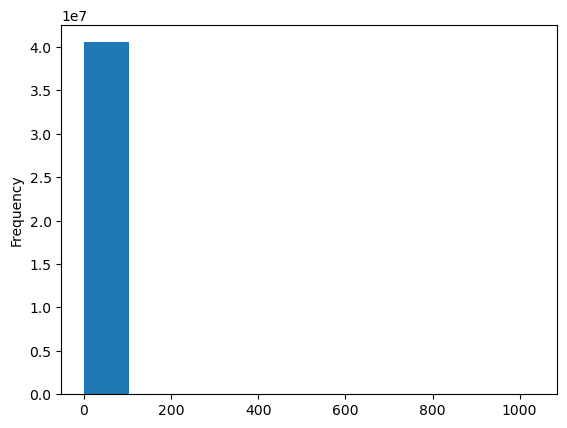

In [76]:
(_df["time"] / pd.Timedelta("1D")).plot.hist()  # bins=np.arange(0,10*24)